In [1]:
%matplotlib notebook
import numpy as np
import matplotlib as mpl
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, Button
from IPython.display import display, HTML


#

In [2]:
#


# useful math functions

def d_dx(a, dx):
    ddx = ( a[:-1] - a[1:] )*(-1/dx) 
    return ddx
def d_dy(a, dy):
    ddy = ( a[:,:-1] - a[:,1:] )*(-1/dy)
    return ddy
def div(u, v, dx, dy):
    div = d_dx(u, dx) + d_dy(v, dy)
    return div


def planegauss(shape, w = 1/2, win=((-2, 2), (-2, 2))): # function to generate a gaussian across a 2d array, used for gaussian initial condition
    h=np.empty(shape, dtype=np.float32)
    npx = np.linspace( win[0][0], win[0][1], shape[0] )
    npy = np.linspace( win[1][0],win[1][1], shape[1] )
    npxx, npyy = np.meshgrid(npx, npy)
    h = np.exp( -np.e * ( npxx*npxx + npyy*npyy ) / (w*w) )
    return (h)




def lingauss(shape, w = 1/2, ax = 0, win = (-2, 2)):
    h=np.empty(shape, dtype=np.float32)
    npx = np.linspace( win[0], win[1], shape[0] )
    npy = np.linspace( win[0], win[1], shape[1] )
    npxx, npyy = np.meshgrid(npy, npx)
    xy = (npyy, npxx)[ax]
    h = np.exp( -np.e * ( xy*xy ) / (w*w) )
    return (h)
#

In [3]:
#

class p():
    g = np.float32(10.0)




        
class initcons():
    
    size = (100, 100) # grid squares (dx)
    
    dx = np.single(100, dtype=np.float32) # meters
    dy = np.single(100, dtype=np.float32) # meters
    lat = np.linspace(-5, 5, size[0]+1)
    lon = np.linspace(175, 185, size[1]+1)
    
    #initial condition constants
    #self.
    h = 100-300*planegauss(size, 1)
#     h = 100*np.ones(size)
    n = 1*lingauss(size, 1/4, 0, (-3, 1)) # intial condition
    u = np.zeros((size[0]+1, size[1]+0)) # global x vel array
    v = np.zeros((size[0]+0, size[1]+1)) # global y vel array


# initcons = initcon()

class State():
    g = 10 # m/s/s
    def __init__(self, dx, dy, lat, lon, h, n, u, v):
        
        self.dx = dx #
        self.dy = dy #
        self.lat = lat
        self.lon = lon
        self.lat, self.lon = np.meshgrid(self.lat, self.lon)
        self.h = h
        
        self.wavespeed = np.sqrt(np.max(self.h)*p.g)
        
        self.n = np.asarray(n, dtype=np.float32)
        self.u = np.asarray(u, dtype=np.float32) # global x vel array
        self.v = np.asarray(v, dtype=np.float32) # global y vel array
        
        
        
        assert (np.isscalar(self.h) or self.h.shape == self.h.shape) # 'or' is short circuit
        self.calcDt()
        
        self.coriolis = (np.pi*np.sin(self.lat))/(43200*self.dt) # rotation speed of the earth dtheta/dt
        
        return
    def cori(self):
#         U = R*cos(phi)*O
#         ui = U+ur
#         ur = ui-U
#         dU/dphi = -R*sin(phi)*O
#         phi = y/R
#         dphi/dt = v/R
#         dU/dt = v*(-sin(phi)*O)
#         dur/dt = dui/dt - dU/dt = v*O*sin(phi)
#         dur/dt = v*O*sin(phi)
        #
        #
        #
        
#         du/dt = v*O*sin(phi)
#         v = (du/dt)/(Osin(phi))
#         dv/dt = (u''/sin(phi)-u'cos(phi)/sin^2(phi)*dphi/dt)/O
        return
    def calcDt(self, fudge = 5):
        self.dt = np.min(self.dx)/(fudge*self.wavespeed)
        return


state1 = State(initcons.dx, initcons.dy, initcons.lat, initcons.lon, initcons.h, initcons.n, initcons.u, initcons.v)


#

In [4]:
#


# display functions


def disp3d(aa, box = (None, None, None), lines=(35,35)):
    xlim = box[0]
    ylim = box[1]
    zlim = box[2]
    if (xlim==None):
        xlim = (0, aa[0].shape[0])
    if (ylim==None): ylim = (0, aa[0].shape[1])
    if (zlim==None):
        ran = np.max(aa[0])-np.min(aa[0])
        zlim = (np.min(aa[0])-ran, np.max(aa[0])+ran)
        zlim = (-2, 2)
    
    x = np.linspace(0, aa[0].shape[0]-1, lines[0], dtype=int)
    y = np.linspace(0, aa[0].shape[1]-1, lines[1], dtype=int)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    
    
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for a in aa:
        A = a[xx,yy]
        ax.plot_wireframe(xx, yy, A)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    
    plt.show()
    
    return


def contour(a):
    x = np.arange(0, a.shape[0], dtype=np.float32)
    y = np.arange(0, a.shape[1], dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    
    plt.figure()
    c = plt.contour(xx, yy, a)
    plt.title("water surface height")
    plt.colorbar()
    
    return c


def motioncon(f):
    z = f[0]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(z)
    cb = fig.colorbar(im)
    tx = ax.set_title('water surface height')
    
    def animate(i):
        im.set_data(f[i])
    
    anim = animation.FuncAnimation(fig, animate, frames=len(f))
    plt.show()
    return anim


def vect(u, v, xlim='default', ylim='default', arws=(10, 10), arwsz=100):
    if (xlim=='default'): xlim = (0, u.shape[0])
    if (ylim=='default'): ylim = (0, v.shape[1])
    arws = (int(arws[0]), int(arws[1]))
    
    x = np.linspace(0, u.shape[0]-1, arws[0], dtype=int)
    y = np.linspace(0, v.shape[1]-1, arws[1], dtype=int)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    uu = u[x,y]
    vv = v[x,y]
    m = np.hypot(uu, vv)
    
    fig, ax = plt.subplots()
    q = ax.quiver(xx, yy, vv, uu, m, scale = 1/arwsz)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()
    
    return q




    

#

<IPython.core.display.Javascript object>


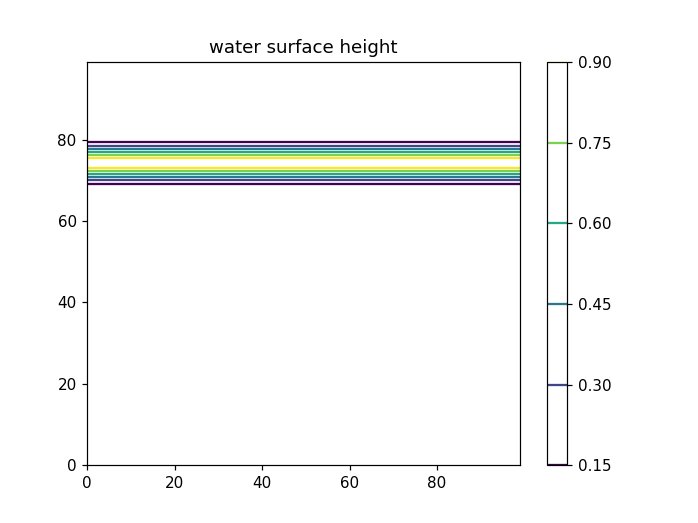

group velocity


<IPython.core.display.Javascript object>


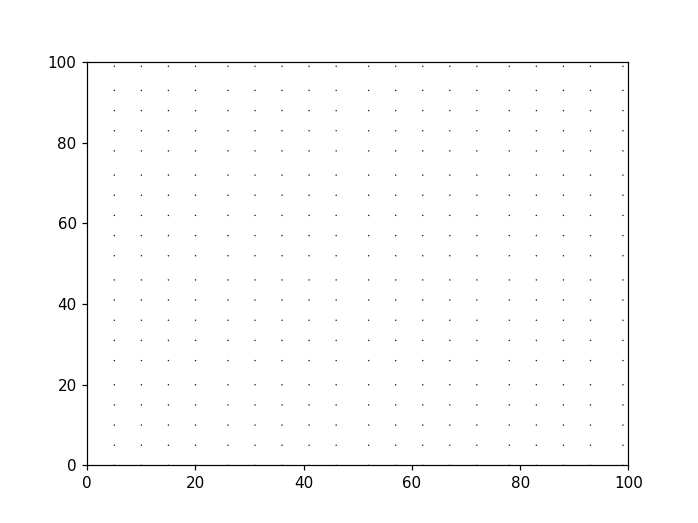

In [5]:
#


#display initial conditions, tests display functions


contour(state1.n)


# print("height")
# disp3d((state1.n, -state1.h)) # 3d wireframe plot

print("group velocity")
vect(d_dx(state1.u, state1.dx), d_dy(state1.v, state1.dy), arws=(20, 20))


#

In [6]:
#




def dndt(h, n, u, v, dx, dy) :
    hx = np.empty((n.shape[0]+1, n.shape[1]), dtype=n.dtype)
    hx[1:-1] = ((h+n)[1:] + (h+n)[:-1])/2 # average to same shape as u
    hx[0] = hx[-1] = 0.0
    hy = np.empty((n.shape[0], n.shape[1]+1), dtype=n.dtype)
    hy[:,1:-1] = ((h+n)[:,1:] + (h+n)[:,:-1])/2 # average to same shape as v
    hy[:,0] = hy[:,-1] = 0.0 # reflective boundaries borders
    hx *= u # momentum of water column.
    hy *= v
    dndt = (div(hx, hy, -dx, -dy))
    return ( dndt )
def dudt(n, dx) :
    dudt = np.empty((n.shape[0]+1, n.shape[1]), dtype=n.dtype)
    dudt[1:-1] = d_dx(n, -dx/p.g)
#     dudt += coriolis*v
    dudt[0] = dudt[-1] = 0# reflective boundaries
    return ( dudt )
def dvdt(n, dy) :
    dvdt = np.empty((n.shape[0], n.shape[1]+1), dtype=n.dtype)
    dvdt[:,1:-1] = d_dy(n, -dy/p.g)
    dvdt[:,0] = dvdt[:,-1] = 0 # reflective boundaries
    return ( dvdt )



def land(h, u ,v):
    #boundaries / land
    coastx = np.less(h, 5) # start a little farther than the coast so H+n is never less than zero
    (u[1:])[coastx] = (u[:-1])[coastx] = 0
    (v[:,1:])[coastx] = (v[:,:-1])[coastx] = 0
    return (u, v)



def forward(h, n, u, v, dt, dx, dy, doland, beta=0): # forward euler timestep
    n1 = n + ( dndt(h, n, u, v, dx, dy) )*dt
    u1 = u + ( beta*dudt(n1, dx) +  (1-beta)*dudt(n, dx) )*dt
    v1 = v + ( beta*dvdt(n1, dy) +  (1-beta)*dvdt(n, dy) )*dt
    
    u1, v1 = doland(h, u1, v1)
    
    return n1, u1, v1


def fbfeedback(h, n, u, v, dt, dx, dy, doland, beta=1/3, eps=2/3): # forward backward feedback

    
    n1g, u1g, v1g = forward(h, n, u, v, dt, dx, dy, doland, beta)
    
    
    n1 = n + 0.5*(dndt(h, n1g, u1g, v1g, dx, dy) + dndt(h, n, u, v, dx, dy))*dt
    u1 = u + 0.5*(eps*dudt(n1, dx)+(1-eps)*dudt(n1g, dx)+dudt(n, dx))*dt
    v1 = v + 0.5*(eps*dvdt(n1, dy)+(1-eps)*dvdt(n1g, dy)+dvdt(n, dy))*dt
    
    
    u1, v1 = doland(h, u1, v1)# how to handle land/coast
    
    
    return n1, u1, v1




def timestep(h, n, u, v, dt, dx, dy): return fbfeedback(h, n, u, v, dt, dx, dy, land)

#

In [7]:
def simulate(state, t):
    h, n, u, v, dx, dy, dt = state.h, state.n, state.u, state.v, state.dx, state.dy, state.dt
    
    # dont try if timstep is zero or negative
    if (dt <= 0):
        return False
    
    f=[n]
    # iterate t times with interval size dt
    itr = 0
    while (itr < t):
        n, u, v = timestep(h, n, u, v, dt, dx, dy) # pushes n, u, v one step into the future
        f.append(n)
        itr += dt
    
    return f

<IPython.core.display.Javascript object>


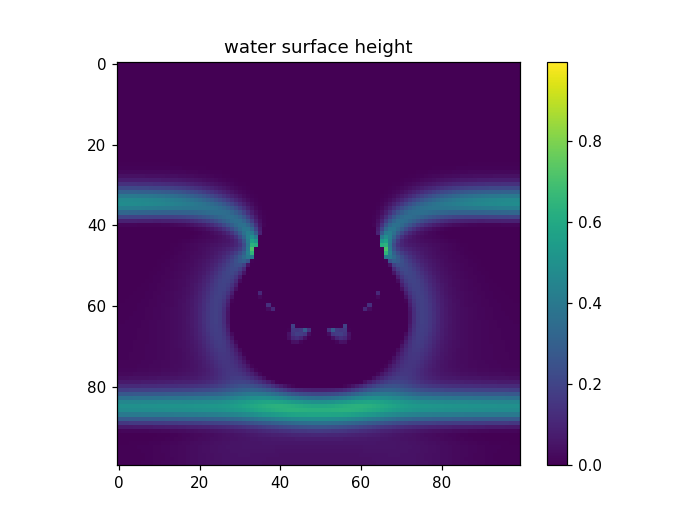

In [8]:

f = simulate(state1, 250)[::5]

motioncon(f)

In [9]:
#wavespeed and differential tests
import unittest



# tests if the wave speed is correct
class testWaveSpeed(unittest.TestCase):
    def setUp(self):
        self.dur = 100 # duration of period to calculate speed over
        self.size = (10, 1000) # grid squares (dx's)
        self.dx = np.single(100, dtype=np.float32) # meters
        self.dy = np.single(100, dtype=np.float32)
        self.lat = np.linspace(0, 0, self.size[0])
        self.lon = np.linspace(0, 0 , self.size[1])
        self.h = 10#*planegauss((sizex, sizey), 1)
        self.n = 1*lingauss(self.size, 1/4, 1) # intial condition
        self.u = np.zeros((self.size[0]+1, self.size[1]+0)) # global x vel array
        self.v = np.zeros((self.size[0]+0, self.size[1]+1)) # global y vel array
    def calcWaveSpeed(self, ar1, ar2, Dt):
        midstrip1 = ar1[:,:int(ar1.shape[1]/2)]
        midstrip2 = ar2[:,:int(ar2.shape[1]/2)]
        peakloc1 = np.argmax(midstrip1)
        peakloc2 = np.argmax(midstrip2)
        speed = (peakloc2 - peakloc2)/Dt
        return speed
    def calcExactWaveSpeed(self):
        ws = np.sqrt(p.g*np.average(self.h))
        return ws
    def test_wavespeed(self):
        self.testStart = State(self.dx, self.dy, self.lat, self.lon, self.h, self.n, self.u, self.v)
        self.testEndN = simulate(self.testStart, self.dur)[-1]
        
        calcedws = self.calcWaveSpeed( self.testStart.n, self.testEndN, self.dur )
        exactws = self.calcExactWaveSpeed()
        
        err = calcedws - exactws
        assert(abs(err) < 11)
    def tearDown(self):
        del(self.dur)
        del(self.dx)
        del(self.dy)
        del(self.lat)
        del(self.lon)
        del(self.size)
        del(self.h)
        del(self.n)
        del(self.u)
        del(self.v)



# differental function test
class testdifferential(unittest.TestCase):
    def setUp(self):
        self.a = np.arange(144) # test input
        self.a = self.a.reshape(12, 12) # 2d array
        self.ddthreshold = 1E-16
        
    def test_ddx(self):
        da = d_dx(self.a, 1)
        diff = np.abs(da[1:-1] - np.mean(da[1:-1]))
        maxdiff = np.max(diff)
        self.assertTrue(np.all(np.abs(da[-1:1] < self.ddthreshold)),"expected zero along borders")
        self.assertTrue(np.all(diff < self.ddthreshold),"Expected constant d_dx less than %f but got %f"%(self.ddthreshold,maxdiff))
    
    def tearDown(self):
        del(self.a)
        del(self.ddthreshold)




unittest.main(argv=['first-arg-is-ignored'], exit=False)

#You can pass further arguments in the argv list, e.g.

#unittest.main(argv=['ignored', '-v'], exit=False)      
#unittest.main()


..
----------------------------------------------------------------------
Ran 2 tests in 0.047s

OK


In [10]:
import timeit

def foo():
    simulate(state1, 250)

print('time to simulate:', timeit.timeit(foo, number=8))

time to simulate: 3.225617966003483
